In [1]:
import dask
from dask.distributed import Client, wait
from dask import delayed

client = Client(n_workers=7, threads_per_worker=1) 
#client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43831,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:42383,Total threads: 1
Dashboard: /proxy/38663/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:41557,


In [2]:
#import all the stuff
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys
import cftime
sys.path.append("/g/data/mn51/users/nb6195/project/gwls/")
import gwl

In [3]:
def location_coords(location_dict, loc_name):
    lat_ind = round((location_dict[loc_name][0] + 44.5)/0.05)
    lon_ind = round((location_dict[loc_name][1] - 112)/0.05)
    return [lat_ind, lon_ind]

In [4]:
#Set parameters
CMIP='CMIP6'
#AGENCY = 'CSIRO' 
#RCM = 'CCAM-v2203-SN'
AGENCY = 'BOM' 
RCM = 'BARPA-R'

#GCM = 'ACCESS-CM2' #ensemble = 'r4i1p1f1' #Done
#GCM = 'ACCESS-ESM1-5' ensemble = 'r6i1p1f1' #Done
#GCM = 'EC-Earth3' ensemble = 'r1i1p1f1' #Done
#GCM = 'MPI-ESM1-2-HR' ensemble = 'r1i1p1f1' #BOM done, no CSIRO
#GCM = 'CESM2' ensemble = 'r11i1p1f1' #Done
#GCM = 'CMCC-ESM2' ensemble = 'r1i1p1f1' #Done
GCM = 'NorESM2-MM' 
ensemble = 'r1i1p1f1' #Done
#GCM = 'CNRM-ESM2-1' ensemble = 'r1i1p1f2' #CSIRO Done, no BOM

#pathway = 'ssp126'
pathway = 'ssp370'

ddir = f"/g/data/kj66/CORDEX/output-{CMIP}/DD/AUST-05i/{AGENCY}/{GCM}"
bdir = f"/g/data/kj66/CORDEX/output-{CMIP}/bias-adjusted-output/AUST-05i/{AGENCY}/{GCM}"

output_dir = '/g/data/ia39/ncra/bushfire/dwi/'

test_index = 'dwi' 
#test_index = 'faux_ffdi'
#test_index = 'p_ffdi'

chosen_gwl = '3.0'

Import tha data for the downscaled, MRNBC, and QME for the chosen index and GWL

In [5]:
#downscaled data
infiles_d=f"/g/data/ia39/ncra/bushfire/dwi/{GCM}/{pathway}/{ensemble}/{RCM}/v1-r1/day/{pathway}_{GCM}_{RCM}_gwl{chosen_gwl}_{test_index}.nc"
data_d = xr.open_dataset(infiles_d)['__xarray_dataarray_variable__']

#MRNBC data
infiles_m=f"/g/data/ia39/ncra/bushfire/dwi/{GCM}/{pathway}/{ensemble}/{RCM}/v1-r1/day/{pathway}_{GCM}_{RCM}_MRNBC_gwl{chosen_gwl}_{test_index}.nc"
data_m = xr.open_dataset(infiles_m)[test_index]

#QME data
infiles_q=f"/g/data/ia39/ncra/bushfire/dwi/{GCM}/{pathway}/{ensemble}/{RCM}/v1-r1/day/{pathway}_{GCM}_{RCM}_QME_gwl{chosen_gwl}_{test_index}.nc"
data_q = xr.open_dataset(infiles_q)[test_index]

In [6]:
location_dict = {
    'Adelaide' : [-34.95, 138.60],
    'Dandenongs' : [-37.8335, 145.3501],
    'Canberra' : [-35.2802, 149.1310],
    'Manjimup' : [-34.2432, 116.1453],
    'Cradle Mountain' : [-41.6800, 145.9400],
    'Kosciuszko' : [-36.4559, 148.2636],
    'Kuitpo' : [-35.2212, 138.6932],
    'Kinglake' : [-37.53291, 145.33964]
}

In [7]:
loc_name = 'Kinglake'

In [8]:
[lat_ind, lon_ind] = location_coords(location_dict, loc_name)

In [9]:
loc_data_d = data_d.isel(lat = lat_ind, lon = lon_ind)
loc_data_m = data_m.isel(lat = lat_ind, lon = lon_ind)
loc_data_q = data_q.isel(lat = lat_ind, lon = lon_ind)

In [12]:
max_ind = loc_data_d.argmax()

In [13]:
low_ind = max(int(max_ind - 20), 0)
up_ind = low_ind + 40
#low_ind = 6562
#up_ind = low_ind + 40

In [86]:
#low_ind

In [87]:
#up_ind

This one for ACCESS

In [88]:
low_date_string = loc_data_d.time[low_ind].values.astype(str)[0:10]
up_date_string = loc_data_d.time[up_ind].values.astype(str)[0:10]

This one for NorESM

In [14]:
low_dt_no_leap = loc_data_d.time[low_ind].values

# Convert to a numeric time value
low_numeric_time = cftime.date2num(low_dt_no_leap, units='days since 2000-01-01')

# Convert back to a standard datetime
low_standard_datetime = cftime.num2date(low_numeric_time, units='days since 2000-01-01')

# Format as a string
low_date_string = low_standard_datetime.strftime('%Y-%m-%d')
#print(low_date_string)  

loc_data_d.time[up_ind]

up_dt_no_leap = loc_data_d.time[up_ind].values

# Convert to a numeric time value
up_numeric_time = cftime.date2num(up_dt_no_leap, units='days since 2000-01-01')

# Convert back to a standard datetime
up_standard_datetime = cftime.num2date(up_numeric_time, units='days since 2000-01-01')

# Format as a string
up_date_string = up_standard_datetime.strftime('%Y-%m-%d')
#print(up_date_string)

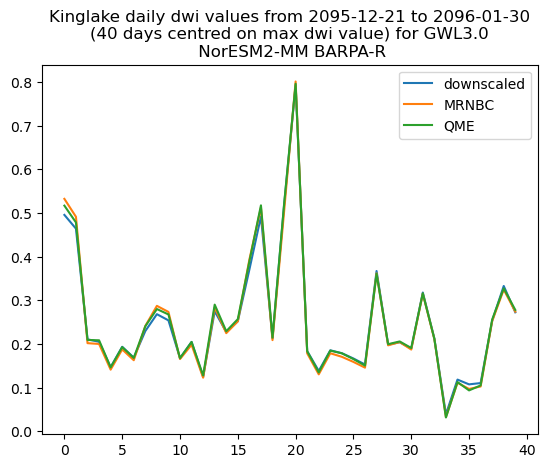

In [15]:
plt.plot(loc_data_d[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_data_m[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_data_q[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, test_index, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Plotting the DWI input data also

read in variable files

In [16]:
var1 = 'tasmaxAdjust'
var2 = 'hursminAdjust'
var3 = 'sfcWindmaxAdjust'

d_var1 = 'tasmax'
d_var2 = 'hursmin'
d_var3 = 'sfcWindmax'

In [17]:
#tasmax
m_infiles1a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
m_infiles1b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_tasmax_master_ds = xr.open_mfdataset(m_infiles1a + m_infiles1b)

q_infiles1a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
q_infiles1b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_tasmax_master_ds = xr.open_mfdataset(q_infiles1a + q_infiles1b)

d_infiles1a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{d_var1}/v20241216/{d_var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
d_infiles1b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{d_var1}/v20241216/{d_var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
D_tasmax_master_ds = xr.open_mfdataset(d_infiles1a + d_infiles1b)

In [18]:
#hursmin
m_infiles2a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
m_infiles2b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_hursmin_master_ds = xr.open_mfdataset(m_infiles2a + m_infiles2b)

q_infiles2a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
q_infiles2b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_hursmin_master_ds = xr.open_mfdataset(q_infiles2a + q_infiles2b)

d_infiles2a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{d_var2}/v20241216/{d_var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
d_infiles2b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{d_var2}/v20241216/{d_var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
D_hursmin_master_ds = xr.open_mfdataset(d_infiles2a + d_infiles2b)

In [19]:
#wind
m_infiles3a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
m_infiles3b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_wind_sp_master_ds = xr.open_mfdataset(m_infiles3a + m_infiles3b)

q_infiles3a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
q_infiles3b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_wind_sp_master_ds = xr.open_mfdataset(q_infiles3a + q_infiles3b)

d_infiles3a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{d_var3}/v20241216/{d_var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
d_infiles3b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{d_var3}/v20241216/{d_var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
D_wind_sp_master_ds = xr.open_mfdataset(d_infiles3a + d_infiles3b)

In [20]:
MRNBC_gwl_tasmax = gwl.get_GWL_timeslice(MRNBC_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
MRNBC_gwl_rh = gwl.get_GWL_timeslice(MRNBC_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
MRNBC_gwl_wind_sp = gwl.get_GWL_timeslice(MRNBC_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

QME_gwl_tasmax = gwl.get_GWL_timeslice(QME_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
QME_gwl_rh = gwl.get_GWL_timeslice(QME_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
QME_gwl_wind_sp = gwl.get_GWL_timeslice(QME_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

D_gwl_tasmax = gwl.get_GWL_timeslice(D_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[d_var1]
D_gwl_rh = gwl.get_GWL_timeslice(D_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[d_var2]
D_gwl_wind_sp = gwl.get_GWL_timeslice(D_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[d_var3]

In [21]:
loc_MRNBC_gwl_tasmax = MRNBC_gwl_tasmax.isel(lat = lat_ind, lon = lon_ind)
loc_MRNBC_gwl_rh = MRNBC_gwl_rh.isel(lat = lat_ind, lon = lon_ind)
loc_MRNBC_gwl_wind_sp = MRNBC_gwl_wind_sp.isel(lat = lat_ind, lon = lon_ind)

loc_QME_gwl_tasmax = QME_gwl_tasmax.isel(lat = lat_ind, lon = lon_ind)
loc_QME_gwl_rh = QME_gwl_rh.isel(lat = lat_ind, lon = lon_ind)
loc_QME_gwl_wind_sp = QME_gwl_wind_sp.isel(lat = lat_ind, lon = lon_ind)

loc_D_gwl_tasmax = D_gwl_tasmax.isel(lat = lat_ind, lon = lon_ind)
loc_D_gwl_rh = D_gwl_rh.isel(lat = lat_ind, lon = lon_ind)
loc_D_gwl_wind_sp = D_gwl_wind_sp.isel(lat = lat_ind, lon = lon_ind)

Plot for tasmax

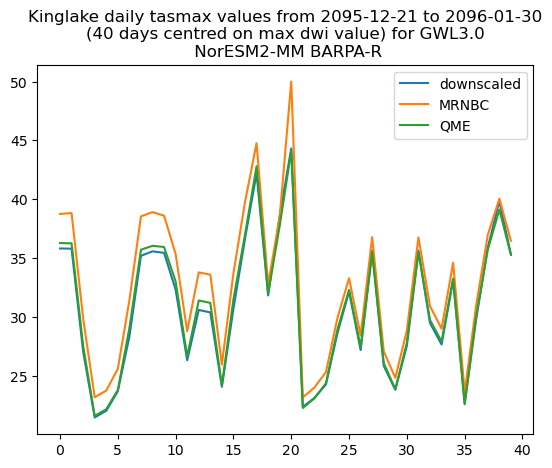

In [22]:
plt.plot(loc_D_gwl_tasmax[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_MRNBC_gwl_tasmax[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_QME_gwl_tasmax[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, d_var1, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Plot for hursmin

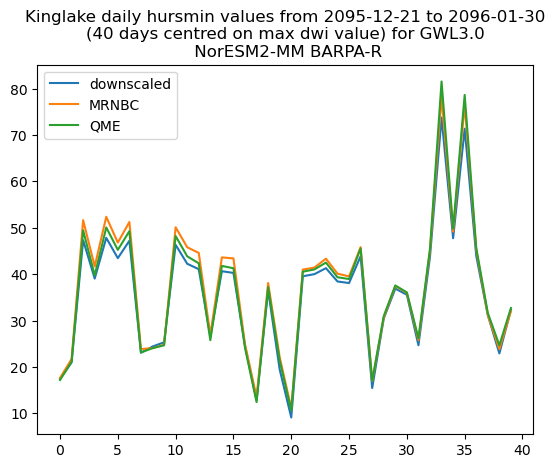

In [23]:
plt.plot(loc_D_gwl_rh[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_MRNBC_gwl_rh[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_QME_gwl_rh[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, d_var2, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Plot for wind

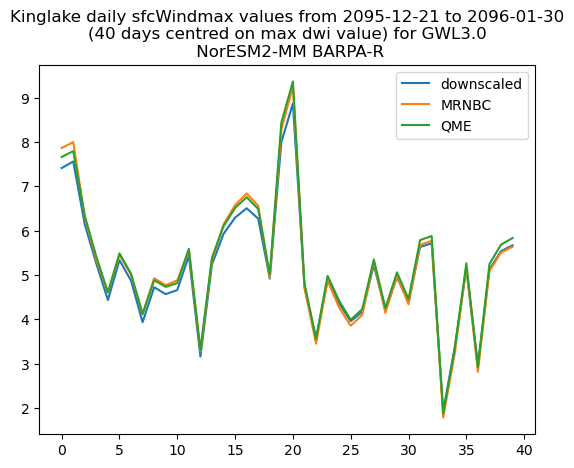

In [24]:
plt.plot(loc_D_gwl_wind_sp[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_MRNBC_gwl_wind_sp[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_QME_gwl_wind_sp[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, d_var3, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Monthly data

In [25]:
mean_loc_data_d = loc_data_d.groupby('time.month').mean('time', keep_attrs=True)
mean_loc_data_m = loc_data_m.groupby('time.month').mean('time', keep_attrs=True)
mean_loc_data_q = loc_data_q.groupby('time.month').mean('time', keep_attrs=True)

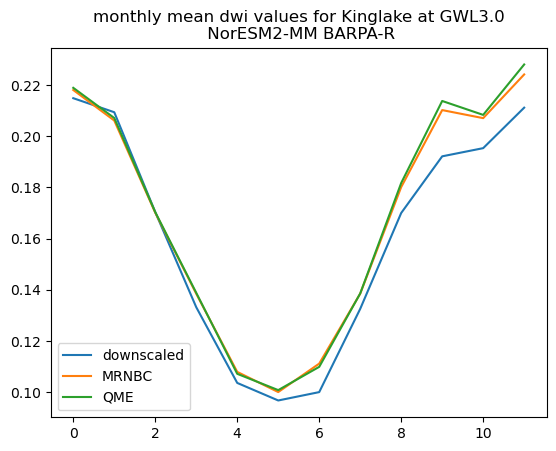

In [26]:
plt.plot(mean_loc_data_d, label = 'downscaled')
plt.plot(mean_loc_data_m, label = 'MRNBC')
plt.plot(mean_loc_data_q, label = 'QME')
plt.title('monthly mean %s values for %s at GWL%s\n %s %s' %(test_index, loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

In [27]:
#perc_loc_data_d = np.percentile(loc_data_d.groupby('time.month'), 90, axis='month')
perc_loc_data_d = loc_data_d.groupby('time.month').quantile(.9)
perc_loc_data_m = loc_data_m.groupby('time.month').quantile(.9)
perc_loc_data_q = loc_data_q.groupby('time.month').quantile(.9)

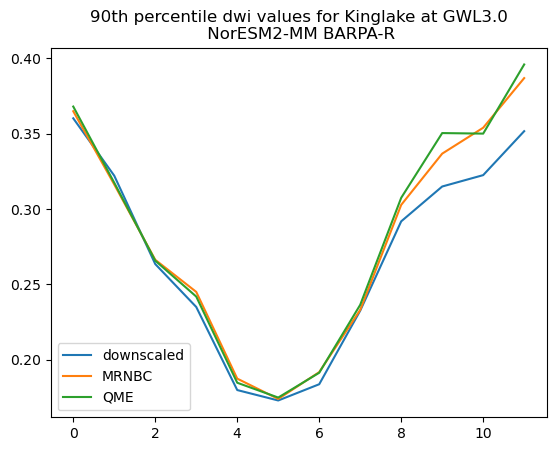

In [28]:
plt.plot(perc_loc_data_d, label = 'downscaled')
plt.plot(perc_loc_data_m, label = 'MRNBC')
plt.plot(perc_loc_data_q, label = 'QME')
plt.title('90th percentile %s values for %s at GWL%s\n %s %s' %(test_index, loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()